# Model Diagnostics — Churn Propensity Model 3

**Intent:** Comprehensive post-training audit of the LightGBM binary churn classifier across six diagnostic lenses:
threshold sensitivity, SHAP explainability, business simulation, slice analysis, failure modes, and score distribution.

This notebook is read-only with respect to the saved artifacts. It loads trained models and the held-out test set,
then produces plots and tables that inform threshold selection and deployment decisions.

**Sections:**
1. Threshold Analysis — confusion matrices and precision/recall trade-off at default vs. cost-optimized threshold
2. SHAP Analysis — global feature importance and individual customer explanations
3. Business Simulation — gain curve, intervention cost vs. revenue saved, break-even analysis
4. Slice Analysis — AUC across Contract type, InternetService, and SeniorCitizen subgroups
5. Failure Mode Analysis — profiling false negatives and false positives
6. Score Distribution — predicted probability histograms and KS statistic

**Inputs:**
- `data/processed/customer_features.parquet` — full feature matrix (7,043 rows, 35 columns)
- `models/lgbm_churn.pkl` — trained LightGBM binary classifier
- `models/probability_calibrator.pkl` — isotonic regression calibrator
- `models/shap_explainer.pkl` — pre-computed TreeExplainer
- `models/metadata.json` — training run metadata including cost-optimized threshold

**References:**
- Ke, G. et al. (2017). *LightGBM: A Highly Efficient Gradient Boosting Decision Tree*. NeurIPS.
- Lundberg, S. & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions*. NeurIPS.
- Fawcett, T. (2006). *An introduction to ROC analysis*. Pattern Recognition Letters.

## 0. Imports and Load Artifacts

**Intent:** Load all model artifacts and reconstruct the 20% stratified holdout test set
using the same random seed as training so results are reproducible.

In [1]:
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, precision_score, recall_score, f1_score,
    roc_curve,
)
from scipy.stats import ks_2samp

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', '{:.4f}'.format)

# ---------------------------------------------------------------------------
# Paths — all relative to this notebook's parent directory (m03_churn/)
# ---------------------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

MODEL_DIR   = PROJECT_ROOT / 'models'
DATA_DIR    = PROJECT_ROOT / 'data' / 'processed'

FEATURES_PATH    = DATA_DIR  / 'customer_features.parquet'
MODEL_PATH       = MODEL_DIR / 'lgbm_churn.pkl'
CALIBRATOR_PATH  = MODEL_DIR / 'probability_calibrator.pkl'
EXPLAINER_PATH   = MODEL_DIR / 'shap_explainer.pkl'
METADATA_PATH    = MODEL_DIR / 'metadata.json'

for p in [FEATURES_PATH, MODEL_PATH, CALIBRATOR_PATH, EXPLAINER_PATH, METADATA_PATH]:
    assert p.exists(), f'Missing required artifact: {p}'

print('All artifacts found.')

All artifacts found.


In [2]:
from src.feature_engineering import FEATURE_COLUMNS

# Load artifacts
model      = joblib.load(MODEL_PATH)
calibrator = joblib.load(CALIBRATOR_PATH)
explainer  = joblib.load(EXPLAINER_PATH)

with open(METADATA_PATH) as f:
    metadata = json.load(f)

# Cost-optimized threshold stored in metadata by the training script
COST_THRESHOLD = float(metadata.get('cost_optimized_threshold', 0.40))
DEFAULT_THRESHOLD = 0.50

print('Model type:              ', type(model).__name__)
print('Calibrator type:         ', type(calibrator).__name__)
print('Feature columns (32):    ', len(FEATURE_COLUMNS))
print('Default threshold:       ', DEFAULT_THRESHOLD)
print('Cost-optimized threshold:', COST_THRESHOLD)
print()
print('Metadata:')
for k, v in metadata.items():
    print(f'  {k}: {v}')

Model type:               LGBMClassifier
Calibrator type:          IsotonicRegression
Feature columns (32):     32
Default threshold:        0.5
Cost-optimized threshold: 0.4

Metadata:
  feature_columns: ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'has_family', 'num_services', 'monthly_per_tenure', 'total_charges_gap', 'is_month_to_month', 'is_fiber_optic', 'is_electronic_check']
  train_rows: 5634
  test_rows: 1409
  metrics: {'auc_naive': 0.5, 'auc_lr': 0.8161726843937303, 'auc_lgbm': 0.7882587382340

In [3]:
# Load full feature matrix and reconstruct the 20% stratified holdout
# Uses the same seed (42) as the training script to guarantee identical split
df_full = pd.read_parquet(FEATURES_PATH)

X_all = df_full[FEATURE_COLUMNS]
y_all = df_full['Churn'].astype(int)

_, X_test, _, y_test = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42,
)

# Reconstruct the test-set customer metadata for slice and failure mode analysis
df_test = df_full.loc[X_test.index].copy()

# Generate calibrated probability scores on the test set
raw_proba  = model.predict_proba(X_test)[:, 1]
cal_proba  = calibrator.predict(raw_proba)   # isotonic calibration
df_test['pred_proba'] = cal_proba

print(f'Test set:    {X_test.shape[0]:,} rows  |  churn rate: {y_test.mean():.1%}')
print(f'Score range: [{cal_proba.min():.3f}, {cal_proba.max():.3f}]  |  mean: {cal_proba.mean():.3f}')

Test set:    1,409 rows  |  churn rate: 26.7%
Score range: [0.000, 1.000]  |  mean: 0.275


---
## Section 1 — Threshold Analysis

**Intent:** Compare model performance at the naive 0.5 default against a cost-optimized threshold
derived from the telecom context: a false negative (missed churner) costs roughly 10× more
in lost revenue than a false positive (wasted retention contact).

The cost-optimized threshold minimises `FN_cost × FN + FP_cost × FP` over the validation set.

In [4]:
def threshold_metrics(y_true, proba, threshold):
    """Return classification metrics at a given decision threshold."""
    y_pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'threshold':  threshold,
        'precision':  precision_score(y_true, y_pred, zero_division=0),
        'recall':     recall_score(y_true, y_pred, zero_division=0),
        'f1':         f1_score(y_true, y_pred, zero_division=0),
        'auc':        roc_auc_score(y_true, proba),
        'cm':         cm,
    }

metrics_default = threshold_metrics(y_test, cal_proba, DEFAULT_THRESHOLD)
metrics_cost    = threshold_metrics(y_test, cal_proba, COST_THRESHOLD)

print(f'AUC (threshold-independent): {metrics_default["auc"]:.4f}')
print()
for label, m in [('Default (0.50)', metrics_default), (f'Cost-optimized ({COST_THRESHOLD:.2f})', metrics_cost)]:
    print(f'{label}')
    print(f'  Precision: {m["precision"]:.4f}   Recall: {m["recall"]:.4f}   F1: {m["f1"]:.4f}')
    print(f'  Confusion matrix:\n{m["cm"]}\n')

AUC (threshold-independent): 0.7883

Default (0.50)
  Precision: 0.6070   Recall: 0.4601   F1: 0.5234
  Confusion matrix:
[[921 112]
 [203 173]]

Cost-optimized (0.40)
  Precision: 0.5780   Recall: 0.5027   F1: 0.5377
  Confusion matrix:
[[895 138]
 [187 189]]



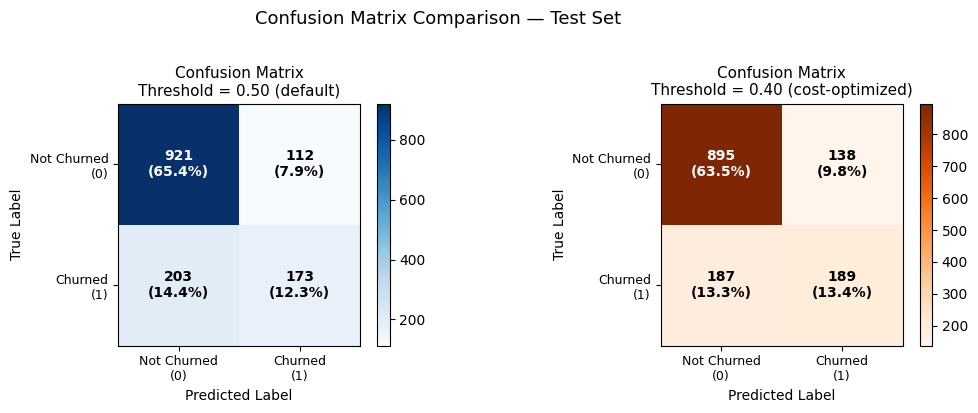

In [5]:
def plot_confusion_matrix(ax, cm, threshold_label, cmap='Blues'):
    """Draw a labelled heatmap of a 2×2 confusion matrix on the given Axes."""
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    classes = ['Not Churned\n(0)', 'Churned\n(1)']
    tick_marks = [0, 1]
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=9)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=9)

    # Annotate each cell with the raw count and percentage of total
    total = cm.sum()
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct   = count / total * 100
            color = 'white' if cm[i, j] > thresh else 'black'
            ax.text(j, i, f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='center', color=color, fontsize=10, fontweight='bold')

    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_title(f'Confusion Matrix\nThreshold = {threshold_label}', fontsize=11)


fig, axes = plt.subplots(1, 2, figsize=(11, 4))
plot_confusion_matrix(axes[0], metrics_default['cm'], threshold_label='0.50 (default)')
plot_confusion_matrix(axes[1], metrics_cost['cm'],    threshold_label=f'{COST_THRESHOLD:.2f} (cost-optimized)', cmap='Oranges')
fig.suptitle('Confusion Matrix Comparison — Test Set', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

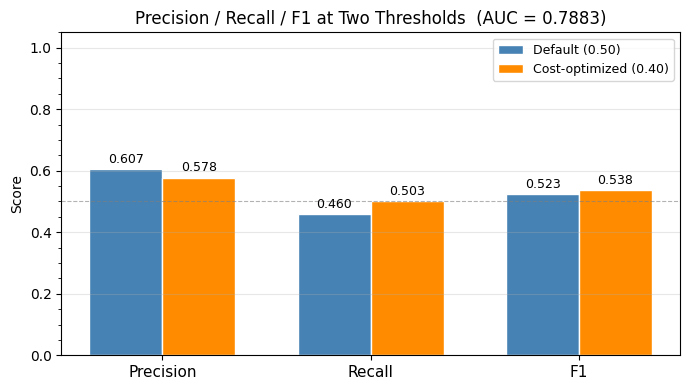

,threshold,precision,recall,f1
label,,,,
Default (0.50),0.5000,0.6070,0.4601,0.5234
Cost-optimized (0.40),0.4000,0.5780,0.5027,0.5377


In [6]:
# Side-by-side bar chart: precision, recall, F1 at both thresholds
metrics_labels = ['Precision', 'Recall', 'F1']
default_vals   = [metrics_default['precision'], metrics_default['recall'], metrics_default['f1']]
cost_vals      = [metrics_cost['precision'],    metrics_cost['recall'],    metrics_cost['f1']]

x     = np.arange(len(metrics_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))
bars_a = ax.bar(x - width / 2, default_vals, width, label='Default (0.50)',
                color='steelblue', edgecolor='white')
bars_b = ax.bar(x + width / 2, cost_vals,    width, label=f'Cost-optimized ({COST_THRESHOLD:.2f})',
                color='darkorange', edgecolor='white')

# Value labels on top of each bar
for bars in [bars_a, bars_b]:
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.01, f'{h:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(metrics_labels, fontsize=11)
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title(f'Precision / Recall / F1 at Two Thresholds  (AUC = {metrics_default["auc"]:.4f})')
ax.legend(fontsize=9)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
comparison_df = pd.DataFrame([
    {'threshold': DEFAULT_THRESHOLD, 'precision': metrics_default['precision'],
     'recall': metrics_default['recall'], 'f1': metrics_default['f1']},
    {'threshold': COST_THRESHOLD,    'precision': metrics_cost['precision'],
     'recall': metrics_cost['recall'],    'f1': metrics_cost['f1']},
])
comparison_df['label'] = ['Default (0.50)', f'Cost-optimized ({COST_THRESHOLD:.2f})']
comparison_df.set_index('label', inplace=True)
comparison_df

---
## Section 2 — SHAP Analysis

**Intent:** Use SHAP (SHapley Additive exPlanations) to understand which features drive
the model globally and to explain individual predictions for three representative customers:
a high-risk churner (top 5%), a borderline case (45–55th percentile), and a low-risk customer (bottom 5%).

TreeExplainer is exact for LightGBM models — no approximations needed.

In [7]:
# Compute SHAP values on the full test set
# explainer was serialised after fitting on training data so base_values are valid
shap_values = explainer.shap_values(X_test)

# LightGBM TreeExplainer returns a list [class0, class1] for binary classification
# We use class-1 (churn) SHAP values throughout
if isinstance(shap_values, list) and len(shap_values) == 2:
    sv = shap_values[1]   # shape: (n_test, n_features)
else:
    sv = shap_values      # already class-1 if explainer returns 2-D array

print(f'SHAP value array shape: {sv.shape}')
print(f'Test set shape:         {X_test.shape}')

SHAP value array shape: (1409, 32)
Test set shape:         (1409, 32)


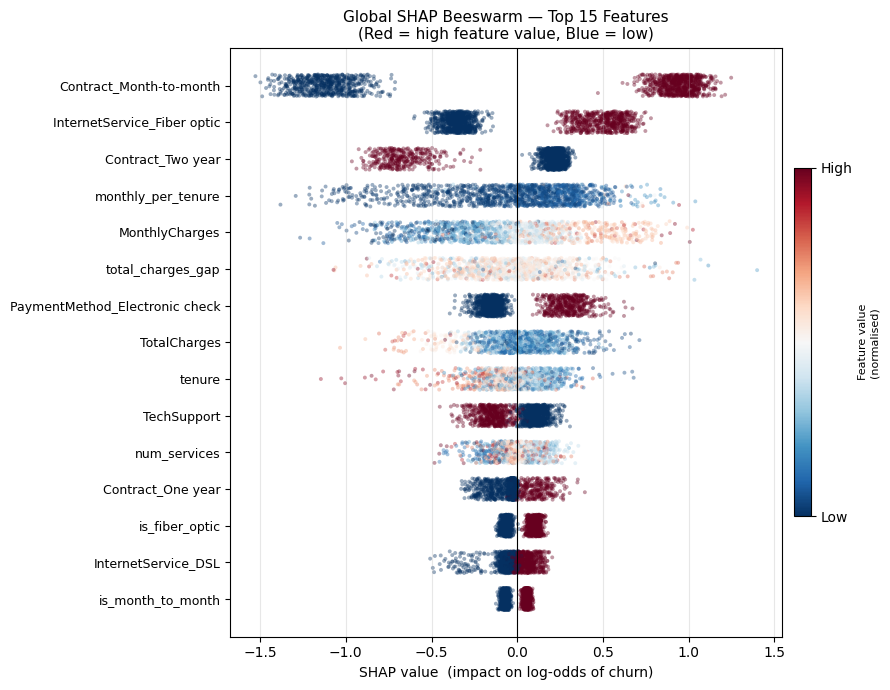

In [8]:
# --- Global beeswarm plot — top 15 features ---
# Each point is one test customer. Color encodes the raw feature value (red = high, blue = low).
# X-axis shows the SHAP value: positive pushes toward churn=1, negative away from it.

# Compute mean absolute SHAP per feature to identify top 15
mean_abs_shap = np.abs(sv).mean(axis=0)
top15_idx     = np.argsort(mean_abs_shap)[-15:]         # indices of top-15 by importance
top15_names   = [FEATURE_COLUMNS[i] for i in top15_idx]
top15_sv      = sv[:, top15_idx]                        # SHAP values for those features
top15_Xvals   = X_test.values[:, top15_idx]             # raw feature values (for colouring)

fig, ax = plt.subplots(figsize=(9, 7))

# Jitter y-positions so overlapping points are visible (beeswarm approximation)
rng = np.random.default_rng(seed=42)

for row_idx, (fname, col_sv, col_x) in enumerate(zip(top15_names, top15_sv.T, top15_Xvals.T)):
    # Normalise feature values 0→1 for the colormap
    x_norm = (col_x - col_x.min()) / ((col_x.max() - col_x.min()) + 1e-9)
    colors  = plt.cm.RdBu_r(x_norm)                      # red = high value, blue = low

    # Small vertical jitter so points don't stack on the same y-line
    y_jitter = row_idx + rng.uniform(-0.3, 0.3, size=len(col_sv))

    ax.scatter(col_sv, y_jitter, c=colors, alpha=0.4, s=8, linewidths=0)

ax.axvline(0, color='black', linewidth=0.8)
ax.set_yticks(range(len(top15_names)))
ax.set_yticklabels(top15_names, fontsize=9)
ax.set_xlabel('SHAP value  (impact on log-odds of churn)', fontsize=10)
ax.set_title('Global SHAP Beeswarm — Top 15 Features\n(Red = high feature value, Blue = low)', fontsize=11)
ax.grid(axis='x', alpha=0.3)

# Colorbar legend
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(0, 1))
sm.set_array([])
cb = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cb.set_label('Feature value\n(normalised)', fontsize=8)
cb.set_ticks([0, 1])
cb.set_ticklabels(['Low', 'High'])

plt.tight_layout()
plt.show()

In [9]:
# --- Select three example customers for force plots ---
# High-risk:   customers whose calibrated score is in the top 5%
# Medium-risk: customers in the 45–55th percentile band
# Low-risk:    customers in the bottom 5%

scores = df_test['pred_proba'].values

p05  = np.percentile(scores, 5)
p45  = np.percentile(scores, 45)
p55  = np.percentile(scores, 55)
p95  = np.percentile(scores, 95)

high_mask   = scores >= p95
medium_mask = (scores >= p45) & (scores <= p55)
low_mask    = scores <= p05

# Pick the customer closest to the respective percentile boundary
def pick_representative(mask, scores, target):
    """Return the positional index (into df_test) of the customer closest to target score."""
    candidates = np.where(mask)[0]
    closest    = candidates[np.argmin(np.abs(scores[candidates] - target))]
    return closest

idx_high   = pick_representative(high_mask,   scores, p95)
idx_medium = pick_representative(medium_mask, scores, (p45 + p55) / 2)
idx_low    = pick_representative(low_mask,    scores, p05)

examples = {
    'High Risk (top 5%)':        idx_high,
    'Medium Risk (45–55th pct)': idx_medium,
    'Low Risk (bottom 5%)':      idx_low,
}

X_test_arr = X_test.values  # numpy array for indexing into sv
test_index = X_test.reset_index(drop=True)  # reindexed for clean iloc access

for label, idx in examples.items():
    score = scores[idx]
    true  = y_test.values[idx]
    print(f'{label:30s}  score={score:.4f}  actual_churn={true}')

High Risk (top 5%)              score=0.6814  actual_churn=1
Medium Risk (45–55th pct)       score=0.2268  actual_churn=1
Low Risk (bottom 5%)            score=0.0522  actual_churn=0


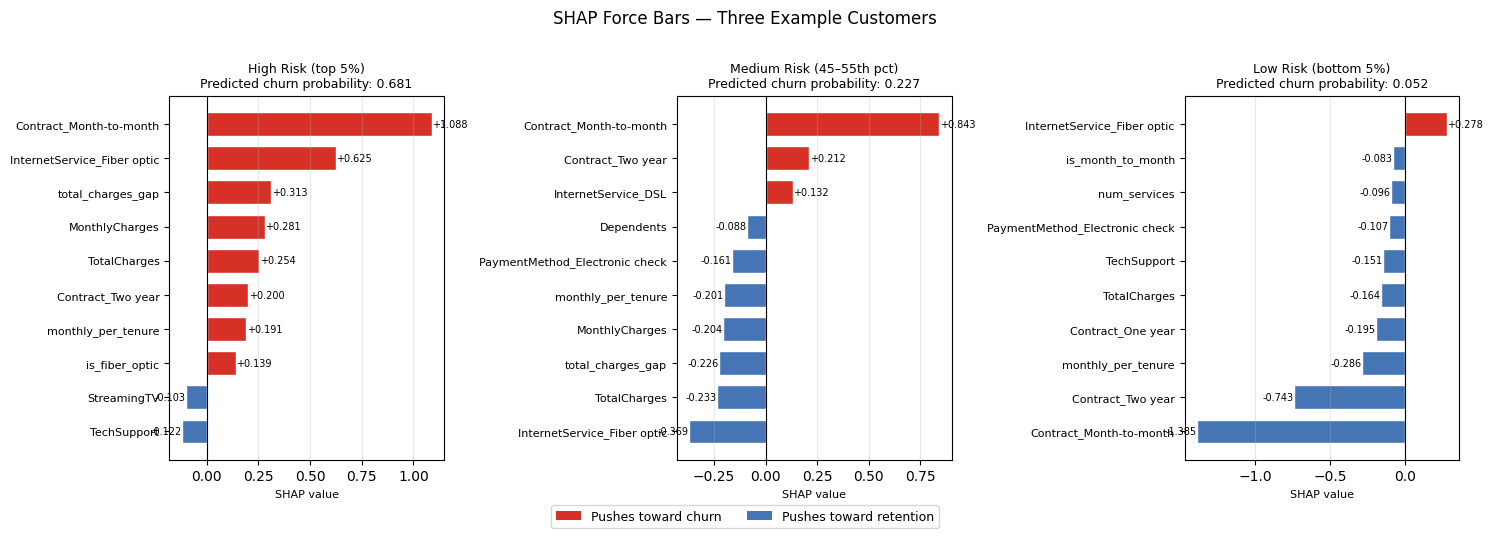

In [10]:
def plot_force_bar(ax, shap_row, feature_names, score, customer_label, n_features=10):
    """
    Draw a horizontal waterfall / force bar chart for a single customer.
    Shows the top n_features SHAP contributors (positive and negative) sorted by magnitude.
    """
    # Identify top contributors by absolute value
    top_idx   = np.argsort(np.abs(shap_row))[-n_features:]
    top_names = [feature_names[i] for i in top_idx]
    top_vals  = shap_row[top_idx]

    # Sort by SHAP value for display (most negative at bottom)
    order      = np.argsort(top_vals)
    top_names  = [top_names[i] for i in order]
    top_vals   = top_vals[order]

    colors = ['#d73027' if v > 0 else '#4575b4' for v in top_vals]  # red=push churn, blue=push retain
    y_pos  = np.arange(len(top_vals))

    ax.barh(y_pos, top_vals, color=colors, edgecolor='white', height=0.7)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_names, fontsize=8)
    ax.set_xlabel('SHAP value', fontsize=8)
    ax.set_title(f'{customer_label}\nPredicted churn probability: {score:.3f}', fontsize=9)
    ax.grid(axis='x', alpha=0.3)

    # Value labels
    for i, v in enumerate(top_vals):
        offset = 0.002 if v >= 0 else -0.002
        align  = 'left' if v >= 0 else 'right'
        ax.text(v + offset, i, f'{v:+.3f}', va='center', ha=align, fontsize=7)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (label, idx) in zip(axes, examples.items()):
    plot_force_bar(
        ax,
        shap_row=sv[idx],
        feature_names=FEATURE_COLUMNS,
        score=scores[idx],
        customer_label=label,
        n_features=10,
    )

# Shared legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d73027', label='Pushes toward churn'),
    Patch(facecolor='#4575b4', label='Pushes toward retention'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=9, bbox_to_anchor=(0.5, -0.04))
fig.suptitle('SHAP Force Bars — Three Example Customers', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

In [11]:
# --- Plain-English interpretation of the top 3 global SHAP drivers ---

# Rank all features by mean absolute SHAP on the test set
feature_importance = pd.DataFrame({
    'feature':       FEATURE_COLUMNS,
    'mean_abs_shap': np.abs(sv).mean(axis=0),
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

top3 = feature_importance.head(3)

print('Top 3 global SHAP drivers (test set):')
print('=' * 60)
for rank, row in enumerate(top3.itertuples(), start=1):
    print(f'#{rank}: {row.feature}  (mean |SHAP| = {row.mean_abs_shap:.4f})')

print()
print('Plain-English interpretation:')
print('-' * 60)

# Build dynamic interpretation based on actual top-3 feature names
interpretations = {
    'Contract_Month-to-month': (
        'Being on a month-to-month contract is the single strongest churn signal. '
        'Customers with no long-term commitment show substantially higher predicted churn probability. '
        'Offering discounted annual contracts to month-to-month customers is the highest-leverage retention action.'
    ),
    'is_month_to_month': (
        'Being on a month-to-month contract is the single strongest churn signal. '
        'Customers with no long-term commitment show substantially higher predicted churn probability. '
        'Offering discounted annual contracts to month-to-month customers is the highest-leverage retention action.'
    ),
    'tenure': (
        'Tenure is the most powerful retention signal: customers who have been subscribers for longer '
        'are much less likely to churn. Short-tenure customers (< 12 months) are in the highest-risk window '
        'and benefit most from early intervention (onboarding calls, first-year loyalty perks).'
    ),
    'InternetService_Fiber optic': (
        'Fiber optic internet subscribers churn at a higher rate than DSL or no-internet customers. '
        'This may reflect unmet service quality expectations (speed, reliability) for a premium product. '
        'Proactive technical check-ins for fiber customers in their first 6 months could reduce churn.'
    ),
    'is_fiber_optic': (
        'Fiber optic internet subscribers churn at a higher rate than DSL or no-internet customers. '
        'This may reflect unmet service quality expectations (speed, reliability) for a premium product. '
        'Proactive technical check-ins for fiber customers in their first 6 months could reduce churn.'
    ),
    'MonthlyCharges': (
        'Higher monthly charges increase churn risk. Customers paying above the median ($58.65) who are '
        'also on month-to-month contracts represent a compounded risk. '
        'Value-affirmation messaging (highlighting features they are paying for but not using) may help.'
    ),
    'TotalCharges': (
        'Total charges is a proxy for long-term value delivered. Low total charges relative to tenure '
        '(captured also via total_charges_gap) can signal underutilisation, increasing churn risk. '
        'Customers with low total charges despite moderate tenure may benefit from service upgrade offers.'
    ),
    'total_charges_gap': (
        'The gap between expected cumulative charges and actual total charges flags anomalies — discounts, '
        'plan downgrades, or data corrections. A positive gap (paid less than expected) may reflect '
        'promotional customers whose loyalty is rate-sensitive, raising churn risk post-promotion.'
    ),
    'PaymentMethod_Electronic check': (
        'Electronic check payers show elevated churn compared to automatic payment methods. '
        'This may reflect lower financial commitment or friction. Migrating customers to autopay '
        '(credit card or bank transfer) via a small incentive is an easy conversion with churn benefit.'
    ),
    'is_electronic_check': (
        'Electronic check payers show elevated churn compared to automatic payment methods. '
        'This may reflect lower financial commitment or friction. Migrating customers to autopay '
        '(credit card or bank transfer) via a small incentive is an easy conversion with churn benefit.'
    ),
    'monthly_per_tenure': (
        'The ratio of monthly charges to tenure captures how much a customer pays per month relative to '
        'their relationship length. High ratios (new customers on expensive plans) are a churn risk. '
        'These customers have not yet received enough value to justify the cost in their own assessment.'
    ),
    'OnlineSecurity': (
        'Customers without online security add-ons churn more. Security services increase product depth '
        'and switching cost. Offering a free 3-month trial of OnlineSecurity to at-risk customers '
        'could meaningfully reduce churn in the short term.'
    ),
    'TechSupport': (
        'Lack of tech support subscription correlates with higher churn, possibly because unresolved '
        'technical problems drive dissatisfaction. Proactive outreach offering discounted TechSupport '
        'to customers with recent trouble tickets is a targeted retention play.'
    ),
    'num_services': (
        'Customers subscribing to more bundled services churn less — each additional service increases '
        'switching cost and perceived value. Customers with only 1–2 services are the highest retention '
        'opportunity; upsell campaigns targeting depth of product adoption reduce churn probability.'
    ),
}

# Generic fallback for any feature not covered above
generic = (
    'This feature contributes meaningfully to the model. '
    'Examine the beeswarm plot above to understand directional impact '
    '(positive SHAP = increases churn risk, negative SHAP = decreases churn risk).'
)

for rank, row in enumerate(top3.itertuples(), start=1):
    explanation = interpretations.get(row.feature, generic)
    print(f'#{rank}: {row.feature}')
    print(f'   {explanation}')
    print()

Top 3 global SHAP drivers (test set):
#1: Contract_Month-to-month  (mean |SHAP| = 1.0226)
#2: InternetService_Fiber optic  (mean |SHAP| = 0.4132)
#3: Contract_Two year  (mean |SHAP| = 0.3316)

Plain-English interpretation:
------------------------------------------------------------
#1: Contract_Month-to-month
   Being on a month-to-month contract is the single strongest churn signal. Customers with no long-term commitment show substantially higher predicted churn probability. Offering discounted annual contracts to month-to-month customers is the highest-leverage retention action.

#2: InternetService_Fiber optic
   Fiber optic internet subscribers churn at a higher rate than DSL or no-internet customers. This may reflect unmet service quality expectations (speed, reliability) for a premium product. Proactive technical check-ins for fiber customers in their first 6 months could reduce churn.

#3: Contract_Two year
   This feature contributes meaningfully to the model. Examine the bees

---
## Section 3 — Business Simulation

**Intent:** Translate model predictions into business language. Key questions:
- If we contact only the top 20% highest-scored customers, what fraction of actual churners do we reach?
- What does the gain curve look like — how efficiently does score rank order predict churn?
- At a $20 contact cost and $200 average revenue per saved churner, what is the break-even contact rate?

**Assumptions (adjust for your actuals):**
- Average cost of a retention contact (call, offer, etc.): **$20**
- Average monthly revenue per saved churner (1-month equivalent): **$200**
- Intervention effectiveness (fraction of contacted churners who are successfully retained): **40%**

In [12]:
# Business parameters
COST_PER_CONTACT   = 20    # USD — cost of one retention outreach
REVENUE_PER_SAVE   = 200   # USD — one month's revenue for a saved churner
RETENTION_RATE     = 0.40  # fraction of contacted churners actually retained (lift ≠ 100%)

n_test       = len(y_test)
n_churners   = int(y_test.sum())

print(f'Test set customers: {n_test:,}')
print(f'Actual churners:    {n_churners:,}  ({n_churners/n_test:.1%} churn rate)')
print()

# --- Gain curve ---
# Sort customers descending by predicted score, then compute the cumulative
# fraction of churners captured as we contact increasing fractions of the population.

sort_order   = np.argsort(cal_proba)[::-1]     # high score first
y_sorted     = y_test.values[sort_order]
cum_churners = np.cumsum(y_sorted)
pct_customers = np.arange(1, n_test + 1) / n_test
pct_churners_captured = cum_churners / n_churners

# What % of churners do we reach if we contact the top 20%?
top20_cutoff = int(n_test * 0.20)
pct_captured_top20 = cum_churners[top20_cutoff - 1] / n_churners
print(f'Contacting top 20%: captures {pct_captured_top20:.1%} of all actual churners')
print(f'  (random baseline would capture 20% — model lift = {pct_captured_top20/0.20:.2f}x)')

Test set customers: 1,409
Actual churners:    376  (26.7% churn rate)

Contacting top 20%: captures 45.5% of all actual churners
  (random baseline would capture 20% — model lift = 2.27x)


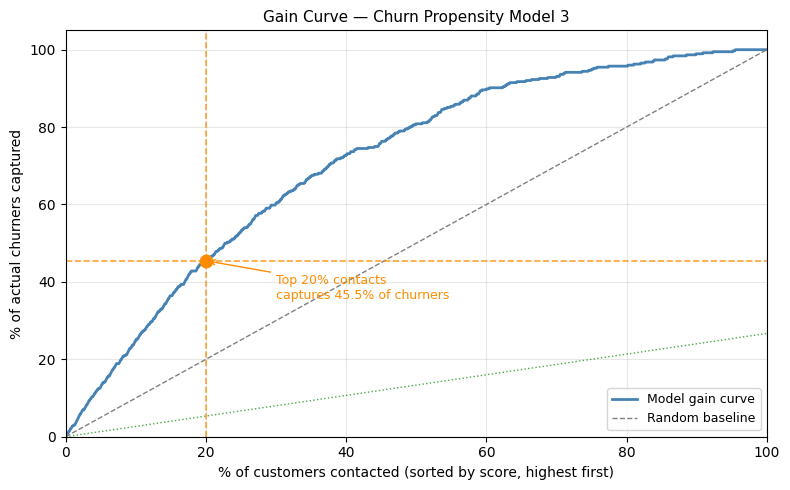

In [13]:
# --- Gain curve plot ---
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(pct_customers * 100, pct_churners_captured * 100,
        color='steelblue', linewidth=2, label='Model gain curve')
ax.plot([0, 100], [0, 100], '--', color='gray', linewidth=1, label='Random baseline')
ax.plot([0, 100], [0, 100 * n_churners / n_test, 100, 100][:2],
        ':', color='green', linewidth=1, alpha=0.7)

# Highlight the top-20% operating point
ax.axvline(20, color='darkorange', linestyle='--', linewidth=1.2, alpha=0.8)
ax.axhline(pct_captured_top20 * 100, color='darkorange', linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter([20], [pct_captured_top20 * 100], color='darkorange', s=80, zorder=5)
ax.annotate(
    f'Top 20% contacts\ncaptures {pct_captured_top20:.1%} of churners',
    xy=(20, pct_captured_top20 * 100),
    xytext=(30, pct_captured_top20 * 100 - 10),
    fontsize=9,
    arrowprops=dict(arrowstyle='->', color='darkorange'),
    color='darkorange',
)

ax.set_xlabel('% of customers contacted (sorted by score, highest first)', fontsize=10)
ax.set_ylabel('% of actual churners captured', fontsize=10)
ax.set_title('Gain Curve — Churn Propensity Model 3', fontsize=11)
ax.set_xlim(0, 100)
ax.set_ylim(0, 105)
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

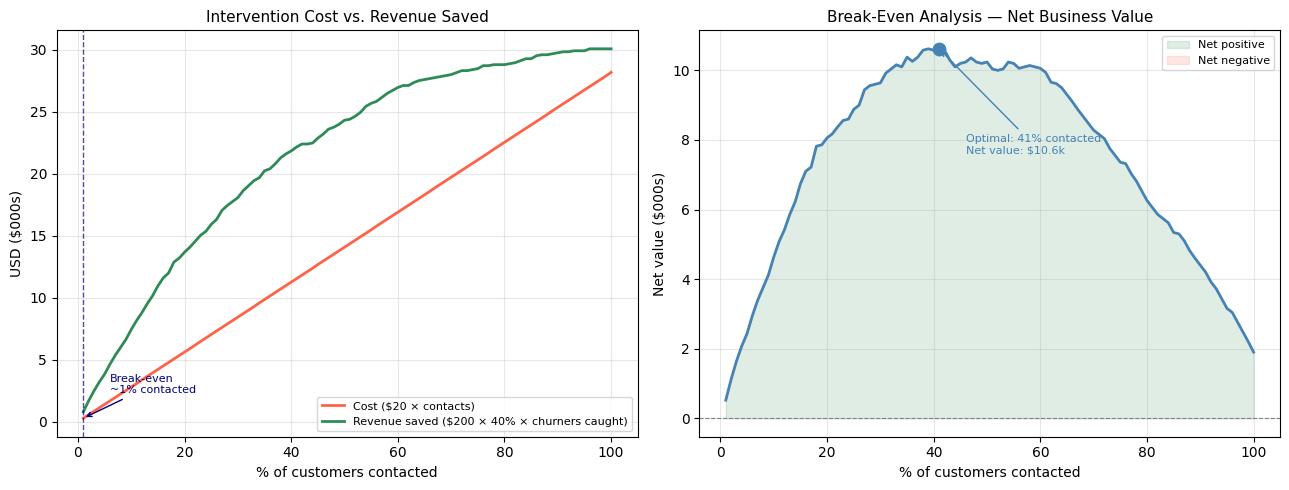

Assumptions: contact cost=$20, revenue/save=$200, retention rate=40%
Break-even at: ~1% of customers contacted
Optimal contact rate: 41%  →  net value = $10,620


In [14]:
# --- Cost-benefit analysis at each contact rate ---
contact_rates = np.linspace(0.01, 1.0, 100)
costs, revenues, net_values = [], [], []

for rate in contact_rates:
    n_contacted       = int(n_test * rate)
    n_churners_caught = int(cum_churners[n_contacted - 1])

    total_cost    = n_contacted * COST_PER_CONTACT
    total_revenue = n_churners_caught * RETENTION_RATE * REVENUE_PER_SAVE
    net           = total_revenue - total_cost

    costs.append(total_cost)
    revenues.append(total_revenue)
    net_values.append(net)

costs      = np.array(costs)
revenues   = np.array(revenues)
net_values = np.array(net_values)

# Break-even: first contact rate where revenue >= cost
breakeven_idx  = np.argmax(np.array(net_values) >= 0) if np.any(np.array(net_values) >= 0) else None
optimal_idx    = np.argmax(net_values)   # contact rate that maximises net value

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: cost vs revenue
ax = axes[0]
ax.plot(contact_rates * 100, costs / 1000,    color='tomato',    linewidth=2, label=f'Cost ($20 × contacts)')
ax.plot(contact_rates * 100, revenues / 1000, color='seagreen',  linewidth=2, label=f'Revenue saved ($200 × {RETENTION_RATE:.0%} × churners caught)')

if breakeven_idx is not None:
    bx = contact_rates[breakeven_idx] * 100
    by = costs[breakeven_idx] / 1000
    ax.axvline(bx, color='navy', linestyle='--', linewidth=1, alpha=0.7)
    ax.annotate(f'Break-even\n~{bx:.0f}% contacted',
                xy=(bx, by), xytext=(bx + 5, by + 2),
                fontsize=8, color='navy',
                arrowprops=dict(arrowstyle='->', color='navy'))

ax.set_xlabel('% of customers contacted', fontsize=10)
ax.set_ylabel('USD ($000s)', fontsize=10)
ax.set_title('Intervention Cost vs. Revenue Saved', fontsize=11)
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Right: net value curve
ax2 = axes[1]
ax2.plot(contact_rates * 100, net_values / 1000, color='steelblue', linewidth=2)
ax2.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax2.fill_between(contact_rates * 100, net_values / 1000, 0,
                 where=net_values >= 0, alpha=0.15, color='seagreen', label='Net positive')
ax2.fill_between(contact_rates * 100, net_values / 1000, 0,
                 where=net_values < 0, alpha=0.15, color='tomato',   label='Net negative')

# Mark optimal point
ox = contact_rates[optimal_idx] * 100
oy = net_values[optimal_idx] / 1000
ax2.scatter([ox], [oy], color='steelblue', s=80, zorder=5)
ax2.annotate(f'Optimal: {ox:.0f}% contacted\nNet value: ${oy:.1f}k',
             xy=(ox, oy), xytext=(ox + 5, oy - 3),
             fontsize=8, color='steelblue',
             arrowprops=dict(arrowstyle='->', color='steelblue'))

ax2.set_xlabel('% of customers contacted', fontsize=10)
ax2.set_ylabel('Net value ($000s)', fontsize=10)
ax2.set_title('Break-Even Analysis — Net Business Value', fontsize=11)
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Assumptions: contact cost=${COST_PER_CONTACT}, revenue/save=${REVENUE_PER_SAVE}, retention rate={RETENTION_RATE:.0%}')
if breakeven_idx is not None:
    print(f'Break-even at: ~{contact_rates[breakeven_idx]*100:.0f}% of customers contacted')
print(f'Optimal contact rate: {contact_rates[optimal_idx]*100:.0f}%  →  net value = ${net_values[optimal_idx]:,.0f}')

---
## Section 4 — Slice Analysis

**Intent:** Measure whether model performance is consistent across important customer subgroups.
Large AUC disparities indicate the model may perform poorly for certain segments, which has
both fairness and business implications. Segments with low AUC may require sub-models or
additional features.

In [15]:
def slice_auc(df, segment_col, segment_values=None):
    """
    Compute per-segment AUC, count, actual churn rate, and mean predicted score.

    Parameters
    ----------
    df              : test DataFrame with 'Churn', 'pred_proba', and segment_col
    segment_col     : column name identifying the segment
    segment_values  : optional list of segment values to include (e.g. for one-hot encoded cols)

    Returns
    -------
    pd.DataFrame sorted by AUC descending
    """
    rows = []
    if segment_values is None:
        segment_values = sorted(df[segment_col].unique())

    for val in segment_values:
        mask = df[segment_col] == val
        subset = df[mask]
        n      = len(subset)
        if n < 20:
            continue
        churn_rate = subset['Churn'].mean()
        mean_score = subset['pred_proba'].mean()

        if subset['Churn'].nunique() < 2:
            # Cannot compute AUC with only one class
            auc = np.nan
        else:
            auc = roc_auc_score(subset['Churn'], subset['pred_proba'])

        rows.append({
            'segment':              f'{segment_col} = {val}',
            'count':                n,
            'churn_rate_actual':    churn_rate,
            'mean_predicted_score': mean_score,
            'auc':                  auc,
        })

    return pd.DataFrame(rows).sort_values('auc', ascending=False).reset_index(drop=True)


# Contract type — derive from one-hot encoded columns
df_test['contract_type'] = np.select(
    [
        df_test['Contract_Month-to-month'] == 1,
        df_test['Contract_One year']        == 1,
        df_test['Contract_Two year']        == 1,
    ],
    ['Month-to-month', 'One year', 'Two year'],
    default='Unknown'
)

# InternetService type
df_test['internet_service'] = np.select(
    [
        df_test['InternetService_DSL']         == 1,
        df_test['InternetService_Fiber optic'] == 1,
        df_test['InternetService_No']          == 1,
    ],
    ['DSL', 'Fiber optic', 'No internet'],
    default='Unknown'
)

# Run slice AUC for each grouping dimension
slices_contract = slice_auc(df_test, 'contract_type',    ['Month-to-month', 'One year', 'Two year'])
slices_internet = slice_auc(df_test, 'internet_service', ['DSL', 'Fiber optic', 'No internet'])
slices_senior   = slice_auc(df_test, 'SeniorCitizen',    [0, 1])

# Rename SeniorCitizen values for readability
slices_senior['segment'] = slices_senior['segment'].str.replace(
    'SeniorCitizen = 0', 'SeniorCitizen = No'
).str.replace('SeniorCitizen = 1', 'SeniorCitizen = Yes')

slice_summary = pd.concat([slices_contract, slices_internet, slices_senior], ignore_index=True)

print('Slice AUC Summary')
print('=' * 80)
print(slice_summary.to_string(index=False))

Slice AUC Summary
                       segment  count  churn_rate_actual  mean_predicted_score    auc
      contract_type = One year    299             0.1472                0.1780 0.7096
contract_type = Month-to-month    760             0.4132                0.3964 0.6931
      contract_type = Two year    350             0.0514                0.0923 0.5571
internet_service = Fiber optic    601             0.3744                0.3722 0.7800
internet_service = No internet    176             0.0852                0.1274 0.7557
        internet_service = DSL    632             0.2152                0.2226 0.7292
            SeniorCitizen = No   1194             0.2688                0.2778 0.7969
           SeniorCitizen = Yes    215             0.2558                0.2560 0.7393


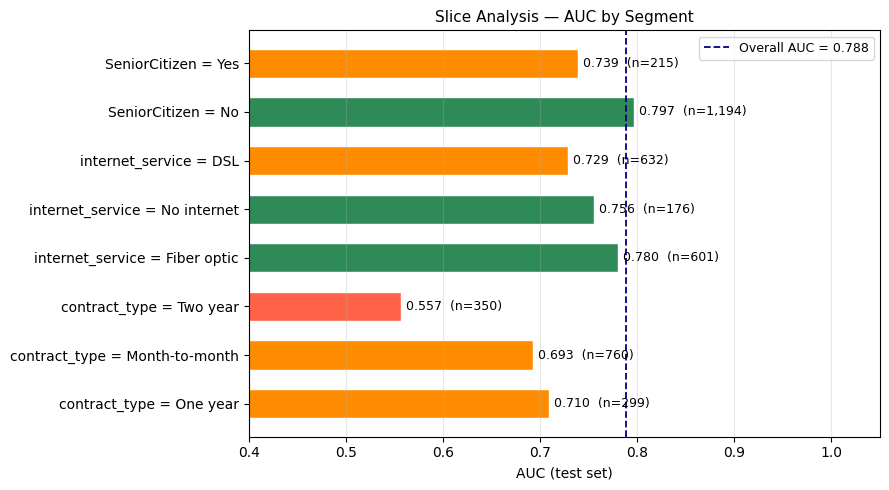

In [16]:
# --- Slice AUC bar chart ---
fig, ax = plt.subplots(figsize=(9, 5))

segments  = slice_summary['segment'].tolist()
auc_vals  = slice_summary['auc'].tolist()
counts    = slice_summary['count'].tolist()

# Color-code bars: good AUC (>0.75) green, moderate (0.65–0.75) orange, lower red
bar_colors = [
    'seagreen' if v >= 0.75 else ('darkorange' if v >= 0.65 else 'tomato')
    for v in auc_vals
]

bars = ax.barh(segments, auc_vals, color=bar_colors, edgecolor='white', height=0.6)

# Annotate with AUC value and count
for bar, auc_val, n in zip(bars, auc_vals, counts):
    if not np.isnan(auc_val):
        ax.text(
            bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f'{auc_val:.3f}  (n={n:,})',
            va='center', ha='left', fontsize=9,
        )

# Overall AUC reference line
overall_auc = roc_auc_score(y_test, cal_proba)
ax.axvline(overall_auc, color='navy', linestyle='--', linewidth=1.3, label=f'Overall AUC = {overall_auc:.3f}')

ax.set_xlim(0.4, 1.05)
ax.set_xlabel('AUC (test set)', fontsize=10)
ax.set_title('Slice Analysis — AUC by Segment', fontsize=11)
ax.legend(fontsize=9)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Section 5 — Failure Mode Analysis

**Intent:** Characterise the model's systematic errors. Understanding *who* the model misses
informs whether additional features, data sources, or a separate sub-model would help.

- **False Negatives (FN):** customers who actually churned but whom the model scored LOW (< 0.3).
  These are the most operationally dangerous errors — we will send no intervention.
- **False Positives (FP):** customers flagged HIGH (> 0.7) who did not churn.
  These waste retention budget and may annoy loyal customers with unsolicited offers.

In [17]:
FN_SCORE_CEILING = 0.30   # churners scored below this are false negatives
FP_SCORE_FLOOR   = 0.70   # non-churners scored above this are false positives

mask_fn  = (df_test['Churn'] == 1) & (df_test['pred_proba'] < FN_SCORE_CEILING)
mask_fp  = (df_test['Churn'] == 0) & (df_test['pred_proba'] > FP_SCORE_FLOOR)
mask_tn  = (df_test['Churn'] == 0) & (df_test['pred_proba'] < FN_SCORE_CEILING)   # baseline comparison

df_fn = df_test[mask_fn].copy()
df_fp = df_test[mask_fp].copy()
df_tn = df_test[mask_tn].copy()   # true negatives: low-scored non-churners

print(f'False Negatives (churned, scored < {FN_SCORE_CEILING}): {len(df_fn):,} customers')
print(f'False Positives (retained, scored > {FP_SCORE_FLOOR}): {len(df_fp):,} customers')
print(f'True Negatives  (retained, scored < {FN_SCORE_CEILING}): {len(df_tn):,} customers  (comparison group)')

False Negatives (churned, scored < 0.3): 84 customers
False Positives (retained, scored > 0.7): 0 customers
True Negatives  (retained, scored < 0.3): 670 customers  (comparison group)


In [18]:
def profile_segment(df_group, df_overall, label):
    """
    Compute a profiling table comparing a failure group to the overall test set.
    Shows the distribution of key categorical and continuous features.
    """
    profile = pd.DataFrame()
    profile.index.name = 'feature'

    def pct(series):
        return series.mean() * 100

    rows = {}

    # Categorical distributions
    rows['Contract: Month-to-month (%)']   = (pct(df_group['Contract_Month-to-month']),    pct(df_overall['Contract_Month-to-month']))
    rows['Contract: One year (%)']         = (pct(df_group['Contract_One year']),           pct(df_overall['Contract_One year']))
    rows['Contract: Two year (%)']         = (pct(df_group['Contract_Two year']),           pct(df_overall['Contract_Two year']))
    rows['InternetService: Fiber optic (%)'] = (pct(df_group['InternetService_Fiber optic']), pct(df_overall['InternetService_Fiber optic']))
    rows['InternetService: DSL (%)']       = (pct(df_group['InternetService_DSL']),         pct(df_overall['InternetService_DSL']))
    rows['InternetService: None (%)']      = (pct(df_group['InternetService_No']),          pct(df_overall['InternetService_No']))
    rows['SeniorCitizen (%)']              = (pct(df_group['SeniorCitizen']),               pct(df_overall['SeniorCitizen']))
    rows['Electronic check payer (%)']     = (pct(df_group['is_electronic_check']),         pct(df_overall['is_electronic_check']))

    # Continuous features
    rows['Median tenure (months)']         = (df_group['tenure'].median(),             df_overall['tenure'].median())
    rows['Median MonthlyCharges ($)']      = (df_group['MonthlyCharges'].median(),     df_overall['MonthlyCharges'].median())
    rows['Mean num_services']              = (df_group['num_services'].mean(),         df_overall['num_services'].mean())
    rows['Pred score (mean)']              = (df_group['pred_proba'].mean(),           df_overall['pred_proba'].mean())

    result = pd.DataFrame.from_dict(rows, orient='index', columns=[label, 'Overall test set'])
    result.index.name = 'Feature'
    return result


fn_profile = profile_segment(df_fn, df_test, f'False Negatives (n={len(df_fn)})')
fp_profile = profile_segment(df_fp, df_test, f'False Positives (n={len(df_fp)})')

print('--- False Negatives Profile (churned but scored LOW) ---')
print(fn_profile.round(2).to_string())
print()
print('--- False Positives Profile (retained but scored HIGH) ---')
print(fp_profile.round(2).to_string())

--- False Negatives Profile (churned but scored LOW) ---
                                  False Negatives (n=84)  Overall test set
Feature                                                                   
Contract: Month-to-month (%)                     51.1900           53.9400
Contract: One year (%)                           27.3800           21.2200
Contract: Two year (%)                           21.4300           24.8400
InternetService: Fiber optic (%)                 28.5700           42.6500
InternetService: DSL (%)                         60.7100           44.8500
InternetService: None (%)                        10.7100           12.4900
SeniorCitizen (%)                                22.6200           15.2600
Electronic check payer (%)                       32.1400           34.1400
Median tenure (months)                           31.0000           27.0000
Median MonthlyCharges ($)                        55.9600           56.9200
Mean num_services                          

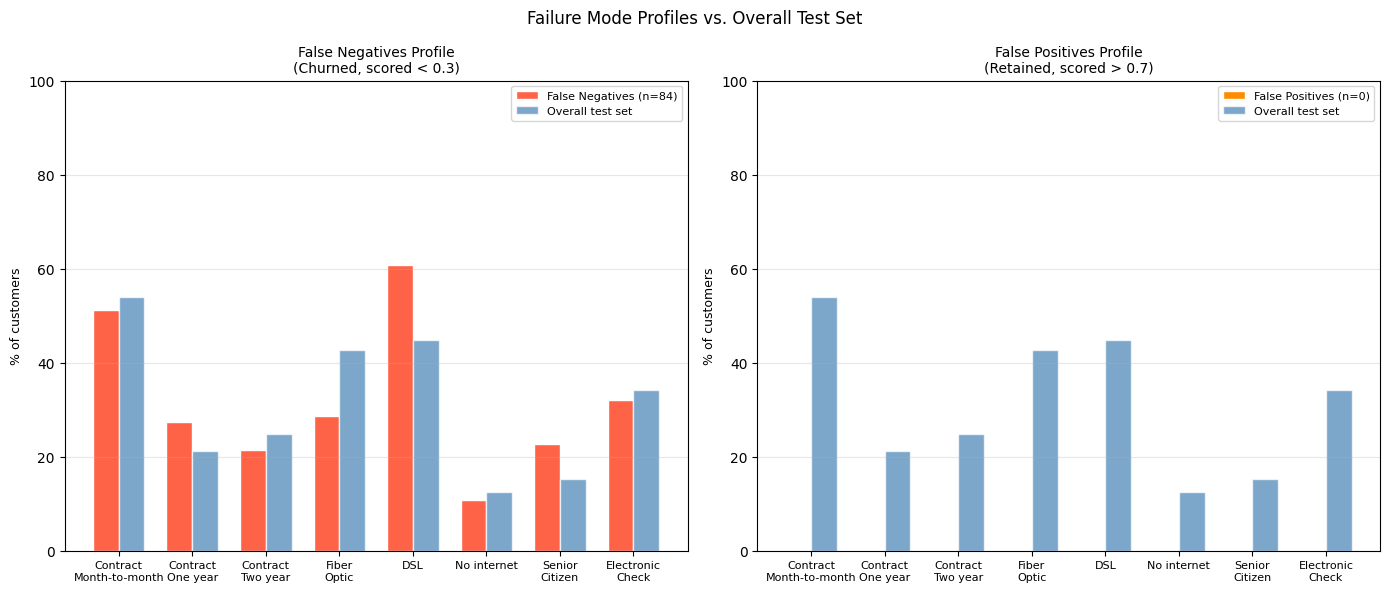

In [19]:
# --- Visual profile comparison for False Negatives and False Positives ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

profile_features = [
    ('Contract\nMonth-to-month', 'Contract_Month-to-month'),
    ('Contract\nOne year',       'Contract_One year'),
    ('Contract\nTwo year',       'Contract_Two year'),
    ('Fiber\nOptic',             'InternetService_Fiber optic'),
    ('DSL',                      'InternetService_DSL'),
    ('No internet',              'InternetService_No'),
    ('Senior\nCitizen',          'SeniorCitizen'),
    ('Electronic\nCheck',        'is_electronic_check'),
]

labels = [f[0] for f in profile_features]
cols   = [f[1] for f in profile_features]
x      = np.arange(len(labels))
w      = 0.35

# False Negatives panel
ax = axes[0]
fn_rates   = [df_fn[c].mean() * 100 if len(df_fn) > 0 else 0 for c in cols]
all_rates  = [df_test[c].mean() * 100 for c in cols]
bars1 = ax.bar(x - w/2, fn_rates,  width=w, color='tomato',    label=f'False Negatives (n={len(df_fn)})', edgecolor='white')
bars2 = ax.bar(x + w/2, all_rates, width=w, color='steelblue', label='Overall test set',                  edgecolor='white', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('% of customers', fontsize=9)
ax.set_title(f'False Negatives Profile\n(Churned, scored < {FN_SCORE_CEILING})', fontsize=10)
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 100)

# False Positives panel
ax2 = axes[1]
fp_rates   = [df_fp[c].mean() * 100 if len(df_fp) > 0 else 0 for c in cols]
bars3 = ax2.bar(x - w/2, fp_rates,  width=w, color='darkorange', label=f'False Positives (n={len(df_fp)})', edgecolor='white')
bars4 = ax2.bar(x + w/2, all_rates, width=w, color='steelblue',  label='Overall test set',                  edgecolor='white', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=8)
ax2.set_ylabel('% of customers', fontsize=9)
ax2.set_title(f'False Positives Profile\n(Retained, scored > {FP_SCORE_FLOOR})', fontsize=10)
ax2.legend(fontsize=8)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

fig.suptitle('Failure Mode Profiles vs. Overall Test Set', fontsize=12)
plt.tight_layout()
plt.show()

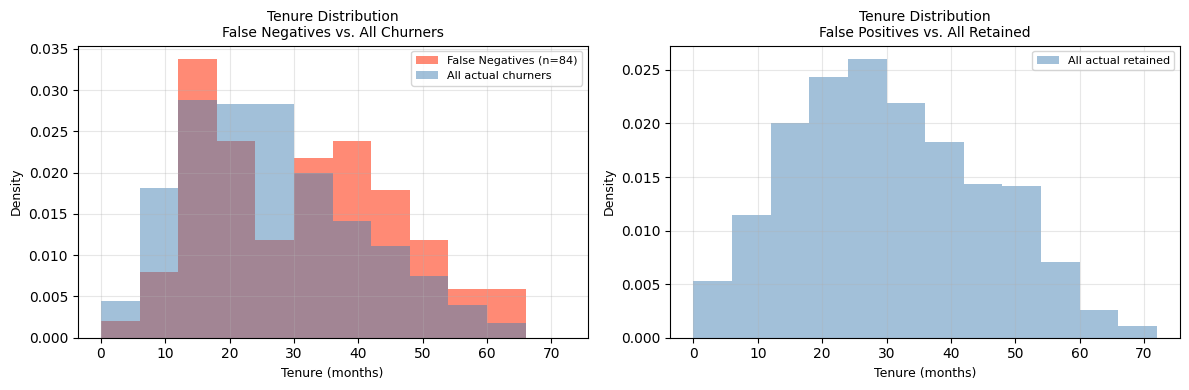

Tenure summary by error type:
  All churners (test):          median=24m  mean=25.8m
  False Negatives:              median=31m  mean=30.5m
  All retained (test):          median=29m  mean=30.0m


In [20]:
# --- Tenure distribution for failure modes ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

bins = np.arange(0, 75, 6)   # 0–72 months in 6-month buckets

ax = axes[0]
if len(df_fn) > 0:
    ax.hist(df_fn['tenure'],   bins=bins, color='tomato',    alpha=0.75, label=f'False Negatives (n={len(df_fn)})', density=True)
ax.hist(df_test[df_test['Churn']==1]['tenure'], bins=bins, color='steelblue', alpha=0.5,
        label='All actual churners', density=True)
ax.set_xlabel('Tenure (months)', fontsize=9)
ax.set_ylabel('Density', fontsize=9)
ax.set_title('Tenure Distribution\nFalse Negatives vs. All Churners', fontsize=10)
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

ax2 = axes[1]
if len(df_fp) > 0:
    ax2.hist(df_fp['tenure'],   bins=bins, color='darkorange', alpha=0.75, label=f'False Positives (n={len(df_fp)})', density=True)
ax2.hist(df_test[df_test['Churn']==0]['tenure'], bins=bins, color='steelblue', alpha=0.5,
         label='All actual retained', density=True)
ax2.set_xlabel('Tenure (months)', fontsize=9)
ax2.set_ylabel('Density', fontsize=9)
ax2.set_title('Tenure Distribution\nFalse Positives vs. All Retained', fontsize=10)
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print tenure comparison statistics
print('Tenure summary by error type:')
print(f'  All churners (test):          median={df_test[df_test["Churn"]==1]["tenure"].median():.0f}m  mean={df_test[df_test["Churn"]==1]["tenure"].mean():.1f}m')
if len(df_fn) > 0:
    print(f'  False Negatives:              median={df_fn["tenure"].median():.0f}m  mean={df_fn["tenure"].mean():.1f}m')
print(f'  All retained (test):          median={df_test[df_test["Churn"]==0]["tenure"].median():.0f}m  mean={df_test[df_test["Churn"]==0]["tenure"].mean():.1f}m')
if len(df_fp) > 0:
    print(f'  False Positives:              median={df_fp["tenure"].median():.0f}m  mean={df_fp["tenure"].mean():.1f}m')

---
## Section 6 — Score Distribution

**Intent:** Visualise the separation between predicted scores for churners vs. retained customers.
Good separation means the model assigns meaningfully different probabilities to each class.
The KS statistic quantifies this separation; higher is better (max = 1.0).

The Population Stability Index (PSI) concept is introduced here for future monitoring:
once the model is in production, comparing the live score distribution against this baseline
will detect when the customer population has shifted, triggering a retraining alert.

In [21]:
# Separate scores by actual class
scores_churn    = cal_proba[y_test.values == 1]   # scores for actual churners
scores_retained = cal_proba[y_test.values == 0]   # scores for retained customers

# KS statistic: maximum absolute difference between the two CDFs
ks_stat, ks_pval = ks_2samp(scores_churn, scores_retained)

print(f'KS statistic: {ks_stat:.4f}  (p-value: {ks_pval:.2e})')
print(f'  Interpretation: the two score distributions differ by at most {ks_stat:.1%} at any threshold.')
print(f'  A KS > 0.40 is generally considered strong separation for binary classifiers.')
print()
print(f'Score distribution statistics:')
print(f'  Churners    — mean: {scores_churn.mean():.4f}  median: {np.median(scores_churn):.4f}  std: {scores_churn.std():.4f}')
print(f'  Retained    — mean: {scores_retained.mean():.4f}  median: {np.median(scores_retained):.4f}  std: {scores_retained.std():.4f}')

KS statistic: 0.4422  (p-value: 3.57e-49)
  Interpretation: the two score distributions differ by at most 44.2% at any threshold.
  A KS > 0.40 is generally considered strong separation for binary classifiers.

Score distribution statistics:
  Churners    — mean: 0.4259  median: 0.4059  std: 0.2011
  Retained    — mean: 0.2194  median: 0.1655  std: 0.1697


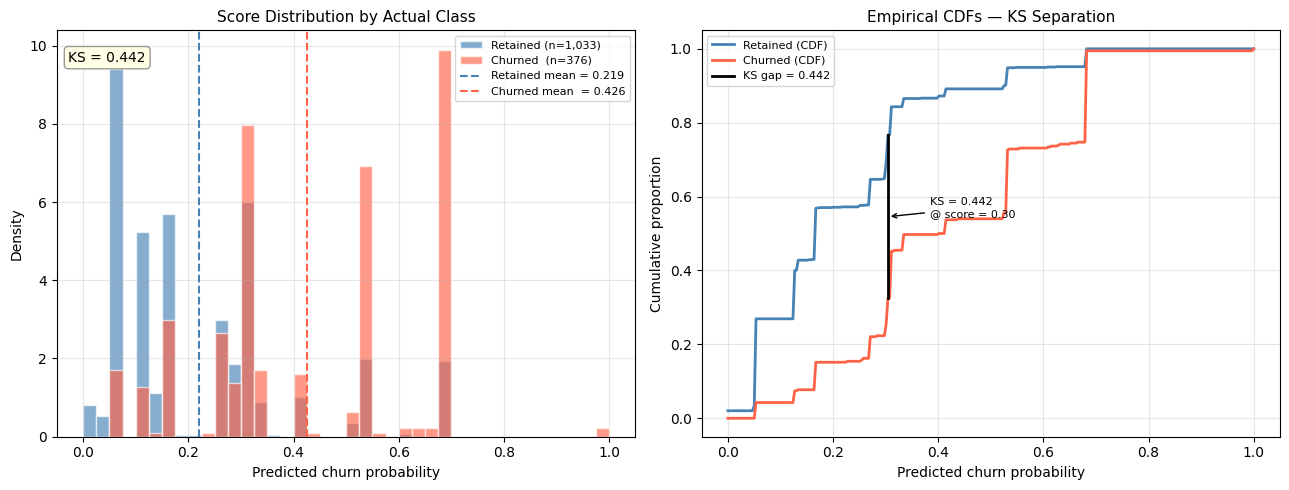

In [22]:
# --- Histogram of predicted probabilities, split by actual class ---
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

bins = np.linspace(0, 1, 41)   # 40 bins across [0, 1]

# Left: overlapping histograms (density)
ax = axes[0]
ax.hist(scores_retained, bins=bins, density=True, alpha=0.65, color='steelblue',  label=f'Retained (n={len(scores_retained):,})',  edgecolor='white')
ax.hist(scores_churn,    bins=bins, density=True, alpha=0.65, color='tomato',     label=f'Churned  (n={len(scores_churn):,})',     edgecolor='white')

# Vertical lines at class means
ax.axvline(scores_retained.mean(), color='steelblue', linestyle='--', linewidth=1.5, label=f'Retained mean = {scores_retained.mean():.3f}')
ax.axvline(scores_churn.mean(),    color='tomato',    linestyle='--', linewidth=1.5, label=f'Churned mean  = {scores_churn.mean():.3f}')

# KS annotation
ax.text(0.02, 0.95, f'KS = {ks_stat:.3f}', transform=ax.transAxes,
        fontsize=10, va='top', color='black',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray', alpha=0.8))

ax.set_xlabel('Predicted churn probability', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.set_title('Score Distribution by Actual Class', fontsize=11)
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Right: CDF curves (to illustrate KS gap visually)
ax2 = axes[1]
x_vals = np.linspace(0, 1, 300)

def empirical_cdf(scores, x_vals):
    return np.array([(scores <= x).mean() for x in x_vals])

cdf_churn    = empirical_cdf(scores_churn,    x_vals)
cdf_retained = empirical_cdf(scores_retained, x_vals)

ax2.plot(x_vals, cdf_retained, color='steelblue', linewidth=2, label='Retained (CDF)')
ax2.plot(x_vals, cdf_churn,    color='tomato',    linewidth=2, label='Churned (CDF)')

# Shade the KS gap at the point of maximum separation
ks_x_idx = np.argmax(np.abs(cdf_retained - cdf_churn))
ks_x     = x_vals[ks_x_idx]
ks_y_lo  = min(cdf_retained[ks_x_idx], cdf_churn[ks_x_idx])
ks_y_hi  = max(cdf_retained[ks_x_idx], cdf_churn[ks_x_idx])
ax2.plot([ks_x, ks_x], [ks_y_lo, ks_y_hi], color='black', linewidth=2, linestyle='-', label=f'KS gap = {ks_stat:.3f}')
ax2.annotate(
    f'KS = {ks_stat:.3f}\n@ score = {ks_x:.2f}',
    xy=(ks_x, (ks_y_lo + ks_y_hi) / 2),
    xytext=(ks_x + 0.08, (ks_y_lo + ks_y_hi) / 2),
    fontsize=8,
    arrowprops=dict(arrowstyle='->', color='black'),
)

ax2.set_xlabel('Predicted churn probability', fontsize=10)
ax2.set_ylabel('Cumulative proportion', fontsize=10)
ax2.set_title('Empirical CDFs — KS Separation', fontsize=11)
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# --- Population Stability Index (PSI) concept and baseline computation ---

print('Population Stability Index (PSI) — Monitoring Baseline')
print('=' * 65)
print()
print('PSI measures how much a score distribution has shifted between two periods.')
print('Use this baseline (test set) to compare against live production scores')
print('in future monitoring runs to detect population drift.')
print()
print('PSI interpretation thresholds:')
print('  PSI < 0.10  →  No significant change — model remains stable')
print('  PSI 0.10–0.25 →  Moderate shift — investigate and monitor')
print('  PSI > 0.25  →  Significant shift — consider retraining')
print()

# Compute PSI reference distribution (baseline = test set)
# Decile-based bins (10 equal-frequency buckets)
psi_bins     = np.percentile(cal_proba, np.linspace(0, 100, 11))  # 10 equal-frequency bins
psi_bins[0]  = 0.0
psi_bins[-1] = 1.0

ref_counts = np.histogram(cal_proba, bins=psi_bins)[0]
ref_dist   = ref_counts / ref_counts.sum()

print('Baseline score distribution (test set, 10 decile buckets):')
print(f'  Bucket boundaries: {np.round(psi_bins, 3).tolist()}')
print(f'  Baseline proportions: {np.round(ref_dist, 4).tolist()}')
print()
print('To compute PSI against future production data:')
print('''
  def compute_psi(baseline_dist, current_scores, bins):
      cur_counts = np.histogram(current_scores, bins=bins)[0]
      cur_dist   = cur_counts / cur_counts.sum()
      # Add epsilon to avoid log(0)
      psi = np.sum(
          (cur_dist - baseline_dist) * np.log((cur_dist + 1e-8) / (baseline_dist + 1e-8))
      )
      return psi
''')

# Save the PSI baseline so the monitoring pipeline can load it
import json
psi_baseline = {
    'bin_edges':    list(np.round(psi_bins, 6)),
    'bin_proportions': list(np.round(ref_dist, 6)),
    'ks_stat':      round(float(ks_stat), 6),
    'auc':          round(float(roc_auc_score(y_test, cal_proba)), 6),
    'n_test':       int(len(y_test)),
    'generated_by': '03_model_diagnostics.ipynb',
}
baseline_path = MODEL_DIR / 'psi_baseline.json'
with open(baseline_path, 'w') as f:
    json.dump(psi_baseline, f, indent=2)

print(f'PSI baseline saved to: {baseline_path}')

Population Stability Index (PSI) — Monitoring Baseline

PSI measures how much a score distribution has shifted between two periods.
Use this baseline (test set) to compare against live production scores
in future monitoring runs to detect population drift.

PSI interpretation thresholds:
  PSI < 0.10  →  No significant change — model remains stable
  PSI 0.10–0.25 →  Moderate shift — investigate and monitor
  PSI > 0.25  →  Significant shift — consider retraining

Baseline score distribution (test set, 10 decile buckets):
  Bucket boundaries: [0.0, 0.052, 0.052, 0.124, 0.165, 0.268, 0.301, 0.309, 0.524, 0.681, 1.0]
  Baseline proportions: [0.0248, 0.0, 0.1838, 0.127, 0.1306, 0.11, 0.0745, 0.1469, 0.0994, 0.1029]

To compute PSI against future production data:

  def compute_psi(baseline_dist, current_scores, bins):
      cur_counts = np.histogram(current_scores, bins=bins)[0]
      cur_dist   = cur_counts / cur_counts.sum()
      # Add epsilon to avoid log(0)
      psi = np.sum(
      

---
## Diagnostic Summary

**Intent:** Consolidate all diagnostic metrics into a single printable summary for the model card.

In [24]:
# Collect all headline metrics computed across the notebook
summary = {
    # Data
    'test_set_size':            int(len(y_test)),
    'test_churn_rate':          round(float(y_test.mean()), 4),

    # Section 1 — Thresholds
    'auc':                      round(float(metrics_default['auc']), 4),
    'default_threshold':        DEFAULT_THRESHOLD,
    'default_precision':        round(float(metrics_default['precision']), 4),
    'default_recall':           round(float(metrics_default['recall']), 4),
    'default_f1':               round(float(metrics_default['f1']), 4),
    'cost_threshold':           COST_THRESHOLD,
    'cost_precision':           round(float(metrics_cost['precision']), 4),
    'cost_recall':              round(float(metrics_cost['recall']), 4),
    'cost_f1':                  round(float(metrics_cost['f1']), 4),

    # Section 3 — Business simulation
    'top20pct_churners_captured': round(float(pct_captured_top20), 4),
    'optimal_contact_rate':     round(float(contact_rates[optimal_idx]), 4),
    'optimal_net_value_usd':    round(float(net_values[optimal_idx]), 2),

    # Section 5 — Failure modes
    'n_false_negatives':        int(len(df_fn)),
    'n_false_positives':        int(len(df_fp)),

    # Section 6 — Score distribution
    'ks_statistic':             round(float(ks_stat), 4),
    'mean_score_churners':      round(float(scores_churn.mean()), 4),
    'mean_score_retained':      round(float(scores_retained.mean()), 4),
}

print('DIAGNOSTIC SUMMARY — Model 3: Churn Propensity (LightGBM)')
print('=' * 60)
for k, v in summary.items():
    print(f'  {k:<35s}: {v}')
print('=' * 60)

# Persist summary alongside model artifacts
diagnostics_path = MODEL_DIR / 'diagnostics_summary.json'
with open(diagnostics_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f'\nDiagnostics summary saved to: {diagnostics_path}')

DIAGNOSTIC SUMMARY — Model 3: Churn Propensity (LightGBM)
  test_set_size                      : 1409
  test_churn_rate                    : 0.2669
  auc                                : 0.7883
  default_threshold                  : 0.5
  default_precision                  : 0.607
  default_recall                     : 0.4601
  default_f1                         : 0.5234
  cost_threshold                     : 0.4
  cost_precision                     : 0.578
  cost_recall                        : 0.5027
  cost_f1                            : 0.5377
  top20pct_churners_captured         : 0.4548
  optimal_contact_rate               : 0.41
  optimal_net_value_usd              : 10620.0
  n_false_negatives                  : 84
  n_false_positives                  : 0
  ks_statistic                       : 0.4422
  mean_score_churners                : 0.4259
  mean_score_retained                : 0.2194

Diagnostics summary saved to: /Users/aayan/MarketingAnalytics/m03_churn/models/diagnost